In [3]:
import umap
import numpy as np
import scipy as sp
import networkx as nx
from node2vec import Node2Vec
from pprint import pprint as pprint
import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import seaborn
import mplcursors
import pickle
import os
import collections
%matplotlib nbagg

In [4]:
G = nx.Graph()

with open('graph.desc', 'r') as fh:
    for line_number, line in enumerate(fh):
        if line_number>=2:
            article_name = line.split("\t")[1][1:][:-2]
            line_number = int(line.split("\t")[0])
            G.add_node(line_number, article_name=article_name)
            
# for i in range(0, len(G.nodes)):
#     print(G.nodes[i])

In [5]:
with open('graph.graph', 'r') as fh:
    for line_number, edge in enumerate(fh):
        src = (edge.split("\t")[0]).split(" ")[0].rstrip()
        dest = (edge.split("\t")[0]).split(" ")[1].rstrip()
        G.add_edge(src,dest)
        # print(src, '->', dest)

In [6]:
article_name = nx.get_node_attributes(G, name='article_name')
article_name[251890]

'Soul music'

In [7]:
pprint(nx.info(G))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 459513\n'
 'Number of edges: 678216\n'
 'Average degree:   2.9519')


In [8]:
min_degree = 10

nodes = [node for node, degree in G.degree() if degree >= min_degree]

In [9]:
list(G.nodes(data=True))[:10]

[(0, {'article_name': 'As Crazy as It Gets'}),
 (1, {'article_name': 'Road to Yesterday (film)'}),
 (2, {'article_name': 'UK Blak'}),
 (3, {'article_name': 'Beach of the War Goddess'}),
 (4, {'article_name': 'Good Vibrations'}),
 (5, {'article_name': 'Cool Jerk'}),
 (6, {'article_name': 'Can We Still Be Friends'}),
 (7, {'article_name': 'I Saw the Light (Todd Rundgren song)'}),
 (8, {'article_name': 'La-La (Means I Love You)'}),
 (9, {'article_name': 'Bang the Drum All Day'})]

In [10]:
subgraph_G = G.subgraph(nodes)

In [11]:
list(subgraph_G.nodes(data=True))[:10]

[('212010', {}),
 ('217357', {}),
 ('198222', {}),
 ('233724', {}),
 ('70780', {}),
 ('133579', {}),
 ('63759', {}),
 ('192364', {}),
 ('162571', {}),
 ('177447', {})]

In [12]:
pprint(nx.info(subgraph_G))

('Name: \n'
 'Type: SubGraph\n'
 'Number of nodes: 33733\n'
 'Number of edges: 263038\n'
 'Average degree:  15.5953')


In [13]:
article_name = nx.get_node_attributes(G, name='article_name')
article_name[251890]

'Soul music'

In [61]:
subgraph_G.degree("67987")

DegreeView({'8': 9})

In [54]:
# Extract largest common component

connected_components = nx.connected_components(subgraph_G)
largest_cc_nodes = max(connected_components, key=len)
largest_cc_graph = subgraph_G.subgraph(largest_cc_nodes)
nx.is_connected(largest_cc_graph)

True

In [55]:
# Count betweenness

subgraph_G_betweenness = nx.betweenness_centrality(largest_cc_graph, k=10000)

In [56]:
print({k: subgraph_G_betweenness[k] for k in list(subgraph_G_betweenness)[:10]})

{'212010': 1.8785979912639518e-07, '217357': 3.0544905558797423e-06, '233724': 5.902344992857761e-06, '198222': 0.00010266155511240549, '133579': 0.0001511785857061778, '63759': 1.2902658126766549e-05, '70780': 1.5358158363193937e-06, '162571': 4.428743015003726e-06, '177447': 6.65150564735702e-05, '59771': 0.0005691229127878181}


In [57]:
files = os.listdir(".")
with open("graph-largest-cc-betweenness-10000.desc", "w") as file:
    for node in subgraph_G_betweenness:
        file.write(str(node) + ' ' + str(subgraph_G_betweenness[node]) + ' "'+article_name[int(node)]+'"\n')

In [15]:
# Degree chart

degrees = [subgraph_G.degree(node) for node in subgraph_G]
degrees_frequency = {x:degrees.count(x) for x in degrees}

In [59]:
degrees_frequency

{1: 379,
 2: 604,
 3: 737,
 4: 1022,
 5: 1333,
 6: 1735,
 7: 2112,
 8: 2482,
 9: 2697,
 10: 2507,
 11: 2143,
 12: 1771,
 13: 1456,
 14: 1286,
 15: 1115,
 16: 996,
 17: 855,
 18: 764,
 19: 664,
 20: 590,
 21: 458,
 22: 423,
 23: 371,
 24: 338,
 25: 353,
 26: 281,
 27: 269,
 28: 212,
 29: 227,
 30: 186,
 31: 173,
 32: 148,
 33: 153,
 34: 142,
 35: 135,
 36: 117,
 37: 118,
 38: 88,
 39: 82,
 40: 81,
 41: 83,
 42: 86,
 43: 56,
 44: 84,
 45: 71,
 46: 63,
 47: 66,
 48: 54,
 49: 60,
 50: 58,
 51: 45,
 52: 41,
 53: 42,
 54: 35,
 55: 38,
 56: 33,
 57: 30,
 58: 38,
 59: 23,
 60: 25,
 61: 28,
 62: 26,
 63: 22,
 64: 30,
 65: 18,
 66: 25,
 67: 19,
 68: 25,
 69: 18,
 70: 18,
 71: 23,
 72: 15,
 73: 16,
 74: 15,
 75: 17,
 76: 9,
 77: 8,
 78: 12,
 79: 5,
 80: 15,
 81: 9,
 82: 4,
 83: 10,
 84: 7,
 85: 7,
 86: 12,
 87: 8,
 88: 7,
 89: 8,
 90: 5,
 91: 10,
 92: 5,
 93: 2,
 94: 4,
 95: 7,
 96: 8,
 97: 7,
 98: 2,
 99: 7,
 100: 6,
 101: 3,
 102: 6,
 103: 4,
 104: 3,
 105: 6,
 106: 6,
 107: 2,
 108: 2,
 109: 2

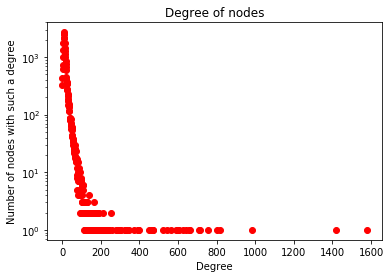

In [19]:
plt.title('Degree of nodes')
plt.xlabel('Degree')
plt.ylabel('Number of nodes with such a degree')
plt.yscale('log')
plt.plot(degrees_frequency.keys(), degrees_frequency.values(), 'ro')
plt.show()

In [ ]:
# Node2Vec

In [ ]:
nodes_count = len(subgraph_G.nodes)

# Precompute probabilities and generate walks
files = os.listdir(".")
if "node2vec.pickle" in files:
    with open("node2vec.pickle", "rb") as file:
        node2vec = pickle.load(file)
else:
    node2vec = Node2Vec(subgraph_G, dimensions=100, walk_length=50, num_walks=500, p=1, q=1, weight_key='weight',
                 workers=8, sampling_strategy=None)

Computing transition probabilities:   4%|▎         | 1247/33733 [00:09<04:20, 124.85it/s]/Users/anna/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Generating walks (CPU: 5):   8%|▊         | 5/62 [16:33<3:16:03, 206.37s/it]

In [ ]:
files = os.listdir(".")
if "node2vec.pickle" not in files:
    with open("node2vec.pickle", "wb") as file:
        pickle.dump(node2vec, file)

In [ ]:
sorted(subgraph_G.degree, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# Embed
# model = node2vec.fit(window=10, min_count=1, batch_words=8)  # Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)
# print(model)

In [ ]:
# Look for most similar nodes
# print (nx.get_node_attributes(G, "Horseland"))

# `model.wv.most_similar('55120')  # Output node names are always strings

In [ ]:
# '62737' in G

In [ ]:
# node_vectors = model.wv
# print(node_vectors)

In [ ]:
# vector_1 = node_vectors['24982']
# print(vector_1)

In [ ]:
# Save embeddings for later use

# node_vectors.save_word2vec_format("art-embedding.txt")

In [ ]:
# Load embeddings

from gensim.models import KeyedVectors
node_vectors_loaded = KeyedVectors.load_word2vec_format("art-embedding.txt")
wv = node_vectors_loaded.vectors

In [ ]:
def interactive_umap(n_neighbors, min_dist, n_components):
    umap_obj = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    transformed = umap_obj.fit_transform(wv)
    plt.figure(figsize=(7.5,7.5))
    seaborn.regplot(x=transformed[:, 0], y=transformed[:, 1], fit_reg=False)    
    
    plt.show()

In [ ]:
interactive(interactive_umap, n_neighbors=15, min_dist=0.5, n_components=3, metric='correlation')